<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #8: Agrupación de textos
`Fecha de entrega: Abril 29, 2021. (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`

In [142]:
import re
import json
import pandas as pd
import numpy as np
import nltk

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [143]:
# Cargar datos
path = 'reviews_vidjew_es.csv'
data = pd.read_csv(path)
data=pd.DataFrame(data['review_body'])
data.head()

,review_body
0,"Buen. Buena calidad, y buena presentación."
1,"Un producto a perfecto, para salir de casa con..."
2,No funciona con Nintendo Switch. No hay forma ...
3,"Recomendado, los utilizo para pc y no me dan n..."
4,El cable funciona bien podria ser un poco mas ...


###  `[10 pts]` Punto 1: Hacer pre-procesamiento del texto

In [144]:
nltk.download('stopwords')
stopwords_sp = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/desktop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [145]:
def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d]+", " ", texto)
    texto = texto.split() # Tokenizar
    texto = [palabra for palabra in texto if palabra not in stopwords_sp]
    texto = " ".join(texto)
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
tfidf = tfidf_vect.fit_transform(data.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns = tfidf_vect.get_feature_names())



###  `[10 pts]` Punto 2: Método del codo para determinar $K$

In [146]:
ks = []
k_inertias = []

for k in range(1,20):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    k_inertia = kmeans.inertia_
    
    ks.append(k)
    k_inertias.append(k_inertia)

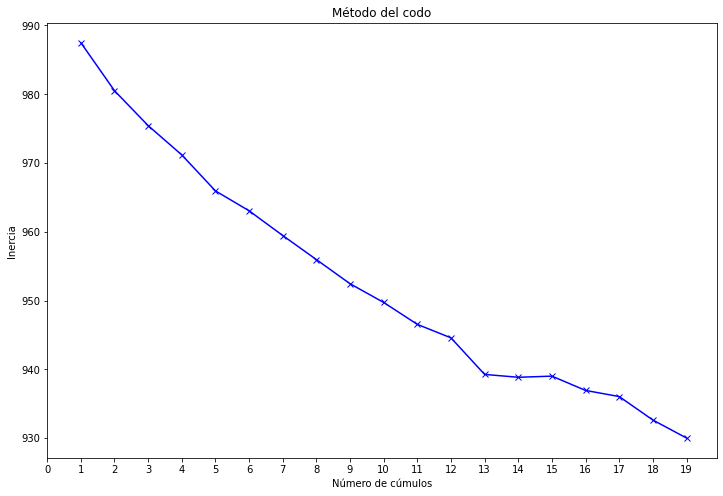

In [147]:
plt.figure(figsize=(12,8))
plt.xlabel("Número de cúmulos")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.plot(ks, k_inertias, 'bx-')
plt.xticks(np.arange(0, 20, step=1))
plt.show()

###  `[10 pts]` Punto 3: Entrenar modelo con el $K$ escogido

In [159]:
k = 9
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)

KMeans(n_clusters=9)

In [160]:
data['cluster'] = model.labels_
data

,review_body,cluster,nombres_clusters
0,"Buen. Buena calidad, y buena presentación.",4,NEGATIVO - JUEGO - ESPERABA MAS
1,"Un producto a perfecto, para salir de casa con...",8,POSITIVO - PRECIO JUSTO
2,No funciona con Nintendo Switch. No hay forma ...,0,NEGATIVO -NO LLEGÓ
3,"Recomendado, los utilizo para pc y no me dan n...",7,POSITIVO - PERO NO LO QUE ESPERABA
4,El cable funciona bien podria ser un poco mas ...,7,POSITIVO - PERO NO LO QUE ESPERABA
...,...,...,...
995,En la foto parece que la cadena sea más gruesa...,7,"POSITIVO JOYAS, LO QUE ESPERABA"
996,"Bien por su precio, la cadena demasiado fina.",7,POSITIVO - PERO NO LO QUE ESPERABA
997,Muy bien!! Ahora tengo organizados los pendien...,7,POSITIVO - PERO NO LO QUE ESPERABA
998,"Las tapas para los joystics no están nada mal,...",0,NEGATIVO -NO LLEGÓ


###  `[15 pts]` Punto 4: Interpretación de los clusters

In [161]:
nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(tfidf_matrix.values)

clust_cnt = data['cluster'].value_counts()
clust_cnt_pct = data['cluster'].value_counts(normalize=True)

centroids = model.cluster_centers_

terms = tfidf_vect.get_feature_names()
order_centroids = centroids.argsort()[:, ::-1]

for i in range(k):
    print(f"Cluster # {i}")
    print(f"Tiene {clust_cnt[i]} registros ({clust_cnt_pct[i]:.2%} de los datos)")
    print()
    
    print("TÉRMINOS MÁS REPRESENTATIVOS")
    for ind in order_centroids[i][:20]:
        print(terms[ind], end=" ")
    print()
    print()
    
    print(f"DOCUMENTOS MÁS REPRESENTATIVOS")
    for vecino in data.iloc[nbrs.kneighbors([centroids[i]])[1][0]].review_body.values:
        print(f" *** {vecino}")
        print()
        
    print()
    print("********************************************")
    print()

Cluster # 0
Tiene 179 registros (17.90% de los datos)

TÉRMINOS MÁS REPRESENTATIVOS
juego si jugar buen español expectativas nintendo mando todas viene cumple gran original solo versión gusto amazon divertido switch gustado 

DOCUMENTOS MÁS REPRESENTATIVOS
 *** No me ha gustado el juego.

 *** Esperaba más del juego.

 *** Un juego para mi hijo. No se ha pasado mucho tiempo jugando con él. No puedo opinar mucho más sobre este juego.


********************************************

Cluster # 1
Tiene 314 registros (31.40% de los datos)

TÉRMINOS MÁS REPRESENTATIVOS
calidad foto bonitos mas tal bonita esperaba plata pequeño aunque ve queda pendientes tiempo fina bastante mala si compra solo 

DOCUMENTOS MÁS REPRESENTATIVOS
 *** Son muy bonitos pero tal vez un poco más grande de lo que me esperaba. El cierre es de calidad.

 *** Es tal cual se ve. Bastante pequeño para mí opinión, es más para niñas pequeñas. Y se ve mucho que no es de calidad. El colgante más pequeño que mi uña y la cadena 

###  `[BONUS: 3 pts]` Visualización usando PCA

In [151]:
# ! pip install plotly
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from plotly.offline import iplot

In [162]:
clusters = {0: 'NEGATIVO -JUEGO ESPERABA MAS',
            1: "POSITIVO - PERO NO LO QUE ESPERABA",
            2: 'NEGATIVO - JOYA - ESPERABA MAS',
            3: 'NEGATIVO - NO LLEGÓ',
            4: 'POSITIVO - CALIDAD PRECIO',
            5: "POSITIVO - JOYA SATISFECHO",
            6: 'NEGATIVO - MAL ESTADO',
            7: 'POSITIVO PRECIO JUSTO',
            8: 'POSITIVO LLEGÓ A TIEMPO',
            }

data['nombres_clusters'] = data['cluster'].apply(lambda val: clusters[val])
data.sample(2)

,review_body,cluster,nombres_clusters
538,"La experiencia en el montaje es de 10, cómo VR...",1,POSITIVO - PERO NO LO QUE ESPERABA
410,"Muy bien, ajustable y bonito. Lo que hay que t...",2,NEGATIVO - JOYA - ESPERABA MAS


In [165]:
pca = PCA(n_components=2)

result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['cluster'] = data.nombres_clusters.values
result['texto'] = data.review_body.apply(lambda val: val[:140])

colorsIdx = {'NEGATIVO -JUEGO ESPERABA MAS': 'darkblue',
             "POSITIVO - PERO NO LO QUE ESPERABA": 'yellow',
             'NEGATIVO - JOYA - ESPERABA MAS': 'green',
             'NEGATIVO - NO LLEGÓ': 'red',
             'POSITIVO - CALIDAD PRECIO': '#2C6E49',
             "POSITIVO - JOYA SATISFECHO": '#5E239D',
             'NEGATIVO - MAL ESTADO': '#5E239D',
             'POSITIVO PRECIO JUSTO': '#14BDEB',
             'POSITIVO LLEGÓ A TIEMPO': '#62B6CB'
             }

result['colores'] = result['cluster'].map(colorsIdx)


result.head()


,X,Y,cluster,texto,colores
0,0.486682,-0.317347,POSITIVO - CALIDAD PRECIO,"Buen. Buena calidad, y buena presentación.",#2C6E49
1,-0.106654,-0.147568,POSITIVO LLEGÓ A TIEMPO,"Un producto a perfecto, para salir de casa con...",#62B6CB
2,-0.071053,-0.028800,NEGATIVO -JUEGO ESPERABA MAS,No funciona con Nintendo Switch. No hay forma ...,darkblue
3,0.031714,0.236176,POSITIVO PRECIO JUSTO,"Recomendado, los utilizo para pc y no me dan n...",#14BDEB
4,0.016539,0.096374,POSITIVO PRECIO JUSTO,El cable funciona bien podria ser un poco mas ...,#14BDEB


In [166]:
trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color=result['colores'].values)) 

layout = go.Layout(title="PCA")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

# Comparación

### `[BONUS 20 pts (validos para cualquier tarea)]` 
### Hacer predicción para estas dos frases de los dos modelos (clasificación y $k$-means)

In [167]:
nuevo = ["Necesitas el juego inicial para eso", "Preciosos estos aretes, buena calidad"]
nuevo_trans = tfidf_vect.transform(nuevo)
[clusters[i] for i in model.predict(nuevo_trans)]



['NEGATIVO -JUEGO ESPERABA MAS', 'POSITIVO - CALIDAD PRECIO']

In [156]:
test = ["Necesitas el juego inicial para eso", "Preciosos estos aretes, buena calidad"]

### `[5 pts]` Punto 5: Preguntas

- Según los resultados del $K$-Means, ¿cuál es la estructura de los datos?
- ¿Qué diferencia notó entre los resultados del taller pasado y este?
- ¿Alguna otra observación?

- Al parecer identifica si el comentario es positivo, si es sobre un juego o una joya, discrimina comentarios sobre calidad, precio, y tiempos de llegada del producto
- Se observa que tiene menos precisión debido a que no hay entrenamiento 